In [31]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [32]:
PATH = os.path.join('.', 'dataset')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, label_mode='int',
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1047 files belonging to 3 classes.


In [33]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, label_mode='int',
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 123 files belonging to 3 classes.


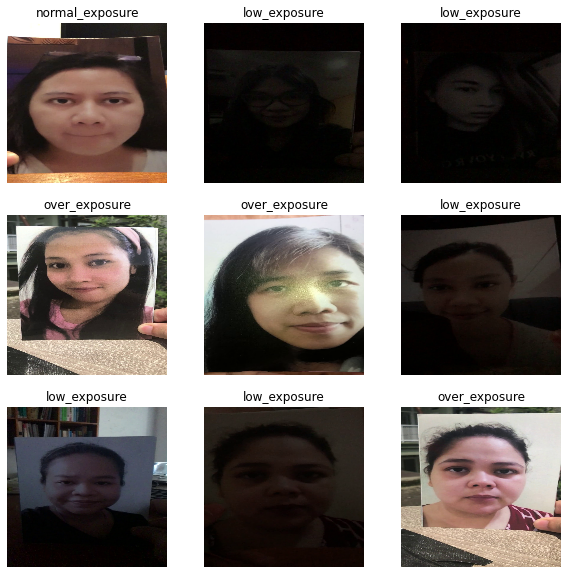

In [34]:
class_names = train_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [35]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [36]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 4
Number of test batches: 0


In [37]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [38]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

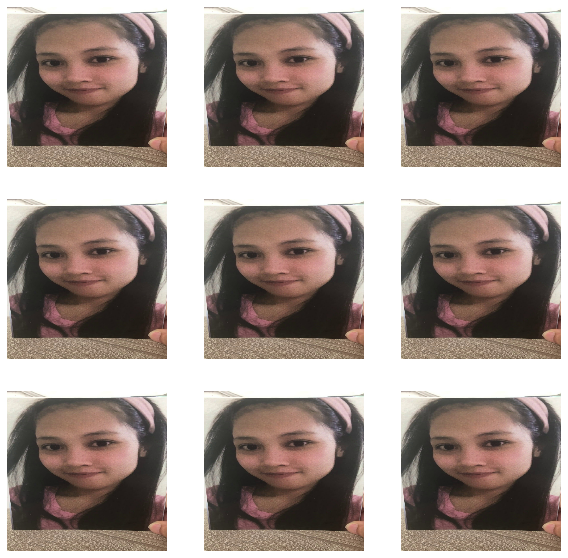

In [39]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [40]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [41]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [42]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [43]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [44]:
base_model.trainable = False

In [45]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [46]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [49]:
prediction_layer = tf.keras.layers.Dense(len(class_names))
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 3)


In [50]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [51]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [53]:
len(model.trainable_variables)

2

In [54]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

4/4 [==============================] - 2s 29ms/step - loss: 1.2336 - accuracy: 0.3984


In [55]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.23
initial accuracy: 0.40


In [56]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
33/33 [==============================] - 7s 127ms/step - loss: 1.2431 - accuracy: 0.4269 - val_loss: 1.1025 - val_accuracy: 0.4878
Epoch 2/10
33/33 [==============================] - 5s 118ms/step - loss: 0.9387 - accuracy: 0.5578 - val_loss: 0.9622 - val_accuracy: 0.5447
Epoch 3/10
33/33 [==============================] - 5s 120ms/step - loss: 0.8352 - accuracy: 0.6275 - val_loss: 0.8677 - val_accuracy: 0.6179
Epoch 4/10
33/33 [==============================] - 5s 117ms/step - loss: 0.7298 - accuracy: 0.6781 - val_loss: 0.7929 - val_accuracy: 0.6504
Epoch 5/10
33/33 [==============================] - 5s 120ms/step - loss: 0.6512 - accuracy: 0.7182 - val_loss: 0.7359 - val_accuracy: 0.6829
Epoch 6/10
33/33 [==============================] - 5s 128ms/step - loss: 0.5965 - accuracy: 0.7488 - val_loss: 0.6936 - val_accuracy: 0.6748
Epoch 7/10
33/33 [==============================] - 6s 136ms/step - loss: 0.5494 - accuracy: 0.7641 - val_loss: 0.6544 - val_accuracy: 0.7073
Epoch 

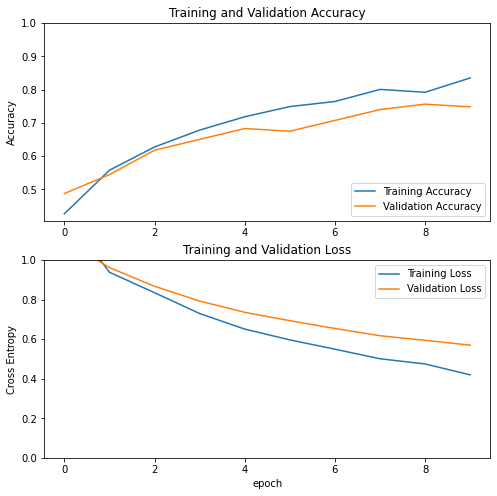

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [58]:
base_model.trainable = True

In [59]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [61]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [63]:
len(model.trainable_variables)

56

In [64]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
33/33 [==============================] - 10s 144ms/step - loss: 0.3299 - accuracy: 0.8634 - val_loss: 0.3640 - val_accuracy: 0.8537
Epoch 11/20
33/33 [==============================] - 5s 122ms/step - loss: 0.2220 - accuracy: 0.9074 - val_loss: 0.2897 - val_accuracy: 0.8943
Epoch 12/20
33/33 [==============================] - 5s 123ms/step - loss: 0.1974 - accuracy: 0.9169 - val_loss: 0.2498 - val_accuracy: 0.9106
Epoch 13/20
33/33 [==============================] - 5s 127ms/step - loss: 0.1399 - accuracy: 0.9427 - val_loss: 0.2184 - val_accuracy: 0.9024
Epoch 14/20
33/33 [==============================] - 5s 133ms/step - loss: 0.1248 - accuracy: 0.9503 - val_loss: 0.2085 - val_accuracy: 0.9187
Epoch 15/20
33/33 [==============================] - 6s 146ms/step - loss: 0.1035 - accuracy: 0.9666 - val_loss: 0.1792 - val_accuracy: 0.9350
Epoch 16/20
33/33 [==============================] - 6s 152ms/step - loss: 0.0920 - accuracy: 0.9656 - val_loss: 0.3037 - val_accuracy: 0.918

In [65]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

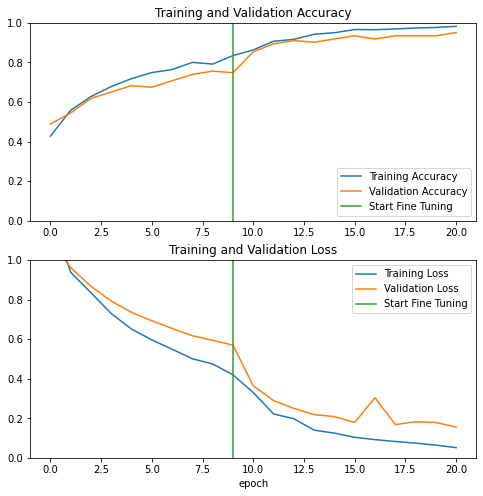

In [67]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [69]:
# loss, accuracy = model.evaluate(test_dataset)
# print('Test accuracy :', accuracy)

In [71]:
# # Retrieve a batch of images from the test set
# image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch).flatten()

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.sigmoid(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

# print('Predictions:\n', predictions.numpy())
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")